# From Deep Learning Foundations to Stable Diffusion
## Lecture 2

## Jupyter Notebook shortcuts

- Shift + Tab opens quick doc for method (do it twice to open at bottom)
- tab inside method after comma shows named args
- ctr+shift+ - splits cell in 2
- shift+M to merge cells
- ctrl+c /ctrl+v works for cells
- alt+ enter creates new cell below
- symbol? opens docs, symbol?? opens docs+sourcecode
- H/h to open keyboard shortcuts, or add em such as to run all above/below

GOAL: build PyTorch and part of FastAI using only 
- python and its std lib
- matplotlib

In [10]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

Get Data:

In [11]:
mnistUrl = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"
pathData = Path('data') # creates a path obj 
pathData.mkdir(exist_ok=True) # create folder named 'data' in cwd
pathGz = pathData/'mnist.pkl.gz' # create filename as pwd/data/mnist.pkl.gz

In [12]:
from urllib.request import urlretrieve

if not pathGz.exists(): # if the data file does not exists 
    urlretrieve(mnistUrl, pathGz) # grab it from url using urlretrieve with (url, path/to/fielname)

In [13]:
# opens file saved as pathGz in read mode, and extracts data from it
# pickle objs py-objs saved to disk
with gzip.open(pathGz, 'rb') as f: # read as binary: 'rb'
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [14]:
# minst contains 60k images 28x28; they come as 1 rank tensor/arrays
type(x_train[0])
# given that we cannot use numpy/pytorch yet let's cast it to list
lst1 = list(x_train[0])
len(lst1) # <- list of 784 els (=28*28 imgs pixels)

784

In [15]:
# let's split an obs as 28 lists of 28 elements using iterators
def chunks(x, sz):
    for i in range(0, len(x), sz): # 0 required!
        yield x[i:i+sz]

In [16]:
chunks(lst1, 28) # creates an iterator/iterable
# this is a generator obj; it is better than most of the other iterables cuz 
# generators don't store all the values in memory at once, useful when working with large data sets or infinite sequence

<generator object chunks at 0x000001C9087DB3D0>

In [7]:
tmpImg = list(chunks(lst1, 28))
print(len(tmpImg), all([len(i)==28 for i in tmpImg]))

# se we have encoded an image as a single list of 28 lists of 28 elements

28 True


In [8]:
# you can call an iterator via iter func
val_iter = chunks(lst1, 28)

In [9]:
next(val_iter) 
# to yield all the contnent in the iterator, when over it raises a StopIteration exception

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

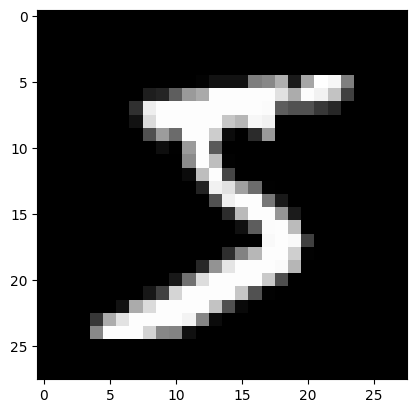

In [10]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)))

In [11]:
from itertools import islice
# let's see another way to do this 
# stream things, one at the time, not storing all in mem

# you can cast a list to an iterator:
it = iter(lst1)

In [12]:
# now we can call next on it one at the time
islice(it, 5) # islice makes generator return only at most the 5 Ns els 
# in this case, while the generator actually consumes its data!

In [13]:
# thus calling islice(it, 5) multiple times will return the first 5 els in the iterator
# untill the iterator is consumed

In [14]:
# so we can redefine chunks as following:
def chunks_(x, sz):
    it = iter(x)
    f = lambda sz: list(islice(it, sz))
    return list(iter(lambda: f(sz), [])) # method to call lambda with 2 args
# calls list(islice(it, sz)); with particular size untill []

# iter will call the lambda untill it gets a [] as return 

In [15]:
tmpImg2 = chunks_(lst1, 28)
print(len(tmpImg2), all([len(i)==28 for i in tmpImg2]))

28 True


# Matrix definition 

In [16]:
# We can index into list of lists as following:
tmpImg[20][15] # to get a single value -> we have defined a matrix!

0.98828125

In [17]:
class Matrix():
    def __init__(self, x): 
        self.x = x
    def __getitem__(self, idxs): # this defines the behavior of []
        print(idxs[0], idxs[1])
        return self.x[idxs[0]][idxs[1]]

In [18]:
img = Matrix(tmpImg2)

In [19]:
img[20, 15]

20 15


0.98828125

In [20]:
# so we can now use the pytorch tensor class (cuz it actually is a matrix)
import torch
from torch import tensor

In [21]:
# and we can now pass to tensor a list of lists to create a matrix, eg:
tensor([[1,2,3], [4,5,6]])

tensor([[1, 2, 3],
        [4, 5, 6]])

In [22]:
imgT = tensor(tmpImg2)
print(imgT.shape)
imgT[20, 15]

torch.Size([28, 28])


tensor(0.9883)

In [23]:
# now we can convert all x_train to tensor
# with map you apply an f to an iterable(s)
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [24]:
# so we can now explore x_train dataset:
x_train.shape
# so it contain 50000 imgs row structured

torch.Size([50000, 784])

In [25]:
# we can thus reshape them to make them 28*28 using auto definition of dimensions:
imgs = x_train.reshape([-1, 28, 28])

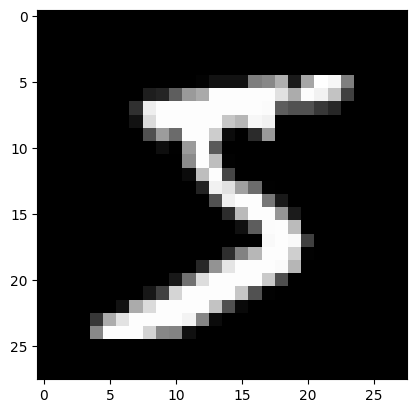

In [26]:
plt.imshow(imgs[0])

# Random Numbers

In [27]:
# wichmann hill algo
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [28]:
seed(12453465)
rnd_state

(13318, 412, 1)

In [29]:
def rand():
    global rnd_state # pull
    x, y, z = rnd_state
    x = (171 * x) % 30268
    y = (171 * y) % 30306
    z = (171 * z) % 30322
    rnd_state = x, y, z # reset
    return (x/30268 + y/30306 + z/30322) % 1.0

# random number generators depend on rnd_state, which is a global var!

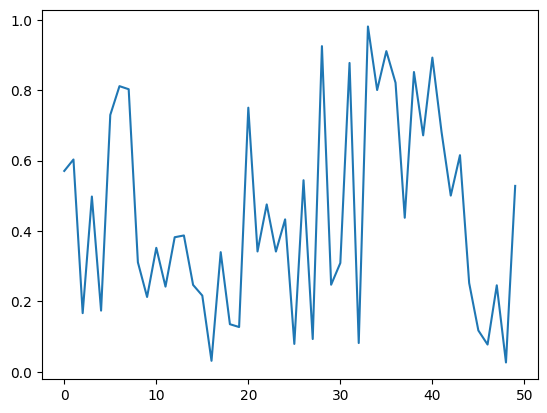

In [30]:
# no explicit relationship between values
plt.plot([rand() for _ in range(50)])

(array([4918., 4984., 5043., 4984., 5032., 4975., 4953., 5006., 5018.,
        5087.]),
 array([1.19355755e-05, 1.00008702e-01, 2.00005468e-01, 3.00002235e-01,
        3.99999001e-01, 4.99995768e-01, 5.99992534e-01, 6.99989300e-01,
        7.99986067e-01, 8.99982833e-01, 9.99979600e-01]),
 <BarContainer object of 10 artists>)

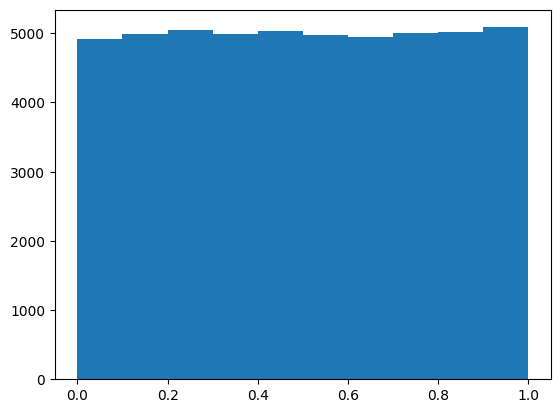

In [31]:
# uniformed dist numbers -> evenly spread values in the range 
plt.hist([rand() for _ in range(50000)])

In [33]:
# remembering that random number generators depend on rnd_state, which is a global var!
# let us create a copy of this python process via os.fork

# this will run only on linux

'''if os.fork():
    print(f'In parent process: {rand()}')
else:
    print(f'In child process: {rand()}')
    os._exit(os.EX_OK)
'''

# the two processes are copies of each other, 
# so they produce the same random number
# since it is based on the rnd_state
# thus u have to be careful when parallelizing stuff cuz of this
# torch and numpy have it wrong!
# rnd_state must be reinitialized in each fork

"if os.fork():\n    print(f'In parent process: {rand()}')\nelse:\n    print(f'In child process: {rand()}')\n    os._exit(os.EX_OK)\n"

In [34]:
%timeit -n 10 list(chunks([rand() for _ in range(70840)], 10))

24.6 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
%timeit -n 10 torch.randn(70840, 10)
# torch is much faster then our code so we are going to use it

3.8 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Forward pass of a MultiLayerPerceptron for MNIST

In [36]:
# we have data, random weights -> now we need matrix multiplication 
# let's consider a batch of size 5 -> 5 images
# their shape is:
x_train[:5].shape

torch.Size([5, 784])

In [37]:
# given that we have 10 labels for output
y_train.unique(return_counts=False) # unique values in y_train

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [38]:
print(torch.bincount(y_train)) # occurrences for each label in y_train
sum(torch.bincount(y_train))

tensor([4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988])


tensor(50000)

In [39]:
# for our single layer mlp input shape: 5x784 
# thus we need thus a weight matrix of shape 784x10 
# to map from data space to out space
# result shape 5x10

In [40]:
torch.manual_seed(1)
# define random weights 
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [41]:
batch1 = x_train[:5]

In [42]:
batch1.shape, weights.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [43]:
batchRows, featureDims = batch1.shape
weightsRows, weightsCols = weights.shape

(batchRows, featureDims), (weightsRows, weightsCols)

((5, 784), (784, 10))

In [44]:
# create container for result
res = torch.zeros([5, 10])
res.shape

torch.Size([5, 10])

In [45]:
for idxRow in range(batchRows): # select row 
    for idxCol in range(weightsCols): # select col 
        for i in range(featureDims): # selected row/col have same dims 
            res[idxRow, idxCol] += batch1[idxRow, i] * weights[i, idxCol]

In [46]:
res

tensor([[  0.9577,  -2.9557,  -2.1148,   0.2679,   1.2794,  -5.2002, -10.3146,
         -15.0880, -17.6923,   0.6007],
        [  6.8906,  -0.3425,   0.7923, -14.7387,   6.9035,  -3.0802, -15.0396,
         -17.1321, -25.3572,  16.2312],
        [-10.1834,   7.3808,   4.1311,   3.2661,  13.8806,  -5.1509,  -7.1424,
          -6.7345,  -6.7882,  -1.5788],
        [  0.9694,   2.3867, -15.2159,   7.7303,  -8.1857, -12.3311,  -5.9767,
          -1.1720,   7.0489,  -1.4185],
        [  6.8513,  14.0698, -11.9205,   2.3367,   4.6249,  -3.3725,  -5.4689,
          -0.6507, -30.5564,   7.8773]])

In [47]:
torch.set_printoptions(precision=2, linewidth=160, sci_mode=False)
import numpy as np
np.set_printoptions(precision=2, linewidth = 140)

In [48]:
res

tensor([[  0.96,  -2.96,  -2.11,   0.27,   1.28,  -5.20, -10.31, -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79, -14.74,   6.90,  -3.08, -15.04, -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,   3.27,  13.88,  -5.15,  -7.14,  -6.73,  -6.79,  -1.58],
        [  0.97,   2.39, -15.22,   7.73,  -8.19, -12.33,  -5.98,  -1.17,   7.05,  -1.42],
        [  6.85,  14.07, -11.92,   2.34,   4.62,  -3.37,  -5.47,  -0.65, -30.56,   7.88]])

In [49]:
def matMul(a, b):
    ar, ac = a.shape
    _, bc = b.shape

    res = torch.zeros([ar, bc])
    for idxRow in range(ar): # select row 
        for idxCol in range(bc): # select col 
            for i in range(ac): # selected row/col have same dims, does dot prod
                res[idxRow, idxCol] += a[idxRow, i] * b[i, idxCol]
    return res

In [50]:
matMul(batch1, weights)

tensor([[  0.96,  -2.96,  -2.11,   0.27,   1.28,  -5.20, -10.31, -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79, -14.74,   6.90,  -3.08, -15.04, -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,   3.27,  13.88,  -5.15,  -7.14,  -6.73,  -6.79,  -1.58],
        [  0.97,   2.39, -15.22,   7.73,  -8.19, -12.33,  -5.98,  -1.17,   7.05,  -1.42],
        [  6.85,  14.07, -11.92,   2.34,   4.62,  -3.37,  -5.47,  -0.65, -30.56,   7.88]])

In [51]:
%timeit matMul(batch1, weights) # 0.76 secs crazy slow

802 ms ± 33.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Numba

In [52]:
# so we have to use something to speed up matrix mul, such as numba which takes 
# py code and turns it into machine code

#! pip install numba
from numba import njit

# first time sees dot() compiles it into machine code and uses it
@njit
def dotProd(a,b):
    # dot prod of two vectors
    res = 0
    for i in range(len(a)):
        res += a[i]*b[i]
    return res
    
    

In [53]:
dotProd(batch1[0].numpy(), weights[:,2].numpy())

-2.1147920218500076

In [54]:
# numba does not work with pytorch so we have to use numpy
from numpy import array

In [55]:
%time dotProd(array([1.,2.,3.]), array([1.,2.,3.]))

CPU times: total: 0 ns
Wall time: 72.8 ms


14.0

In [56]:
# since it was the first time it executed dotProd, it had to compile it,
# now that it is compiled it is much faster
%time dotProd(array([1.,2.,3.]), array([1.,2.,3.]))

CPU times: total: 0 ns
Wall time: 0 ns


14.0

In [57]:
# so we can now rewrite matMul using dotProd
def matMul(a, b):
    ar, ac = a.shape
    _, bc = b.shape

    res = torch.zeros(ar, bc)
    for idxRow in range(ar): # select row 
        for idxCol in range(bc): # select col 
            res[idxRow, idxCol] = dotProd(a[idxRow], b[:, idxCol])
    return res


In [58]:
# so now we test
# 1) correctness
# 2) speed

# 1) correctness
# !pip install fastai
from fastcore.test import *
test_close(res, matMul(batch1.numpy(), weights.numpy())) # if this does not raise then ok

In [59]:
%timeit -n 50 matMul(batch1.numpy(), weights.numpy())

400 µs ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [60]:
res

tensor([[  0.96,  -2.96,  -2.11,   0.27,   1.28,  -5.20, -10.31, -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79, -14.74,   6.90,  -3.08, -15.04, -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,   3.27,  13.88,  -5.15,  -7.14,  -6.73,  -6.79,  -1.58],
        [  0.97,   2.39, -15.22,   7.73,  -8.19, -12.33,  -5.98,  -1.17,   7.05,  -1.42],
        [  6.85,  14.07, -11.92,   2.34,   4.62,  -3.37,  -5.47,  -0.65, -30.56,   7.88]])

In [61]:
matMul(batch1.numpy(), weights.numpy())

tensor([[  0.96,  -2.96,  -2.11,   0.27,   1.28,  -5.20, -10.31, -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79, -14.74,   6.90,  -3.08, -15.04, -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,   3.27,  13.88,  -5.15,  -7.14,  -6.73,  -6.79,  -1.58],
        [  0.97,   2.39, -15.22,   7.73,  -8.19, -12.33,  -5.98,  -1.17,   7.05,  -1.42],
        [  6.85,  14.07, -11.92,   2.34,   4.62,  -3.37,  -5.47,  -0.65, -30.56,   7.88]])

# Element wise operations:
- eg sum, masking 

In [62]:
m = tensor([[1.,2.,3],
            [4.,5.,6],
            [7.,8.,9]
           ]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

## Frobenious norm:
$$\|A\|_\text{F} = \sqrt{\sum_{j,i=1}^n |a_{ij}|^2}$$



In [63]:
fn = ((m*m).sum()).sqrt();fn

tensor(16.88)

In [64]:
a = tensor([1,2,3])
b = tensor([2,2,2])
a*b

# * is an element wise operation we can replace the dotProd above with this!

tensor([2, 4, 6])

In [65]:
def matMul(a, b):
    ar, ac = a.shape
    _, bc = b.shape

    res = torch.zeros(ar, bc)
    for idxRow in range(ar): # select row 
        for idxCol in range(bc): # select col 
            #res[idxRow, idxCol] = (a[idxRow]* b[:, idxCol]).sum()
            res[idxRow, idxCol] = torch.dot(a[idxRow], b[:, idxCol])
    return res

In [66]:
# since we are not using numba anymore we can omit np
test_close(res, matMul(batch1, weights))

In [67]:
%timeit -n 50 matMul(batch1, weights)

773 µs ± 39.9 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


# Broadcasting
What happens multiply add etc if we have array with different shapes


In [68]:
# eg
t = tensor([1,2,4])
t>0, t.shape # it's just as t > tensor([0,0,0,0])

(tensor([True, True, True]), torch.Size([3]))

In [69]:
t+1  # same idea: 1 is broadcasted to have the dims of t

tensor([2, 3, 5])

With scalars its easy, let's now see broadcasting a vector to a matrix

In [70]:
c = tensor([10, 20, 30.]); c

tensor([10., 20., 30.])

In [71]:
m # let's consider c and m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [72]:
m + c # c has been broadcasted over each row. How this happens?

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

## expand_as Very important! 

In [73]:
c1 = c.expand_as(m); c1 # so c1 is what is actually summed
# s.t. have matching shape

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [74]:
# but c1 does not copy c in mem! How?
c1.storage()

C:\Users\MarcoNobile\AppData\Local\Temp\ipykernel_31352\210543576.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  c1.storage()


 10.0
 20.0
 30.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 3]

In [75]:
c1.stride(), c1.shape # before expand c had shape torch.Size([3])
# it has a stride of 0 across the rows -> does not get copied, it stays there:
# Stride is the jump necessary to go from one element to the next one in 
# the specified dimension input dim. default dim = 0 -> rowwise

((0, 1), torch.Size([3, 3]))

In [76]:
# let's consider c
c2 = c.unsqueeze(0); # c[None,: ] or c[None] is the same
c.shape, c2.shape
# unsqueeze(0) adds a unit axis ie a dimension over the first ax

(torch.Size([3]), torch.Size([1, 3]))

In [77]:
c2, c2.shape # a matrix with 1 row and 3 cols

(tensor([[10., 20., 30.]]), torch.Size([1, 3]))

In [78]:
c3 = c.unsqueeze(1); 
c.shape, c3.shape
# c[None,: ] or c[..., None] is the same; ... all previous dims

(torch.Size([3]), torch.Size([3, 1]))

In [79]:
c3, c3.shape # a matrix with 3 rows and 1 col

(tensor([[10.],
         [20.],
         [30.]]),
 torch.Size([3, 1]))

In [80]:
# we can now broadcast instead of over rows but over cols with the (3,1) matrix
c4 = c3.expand_as(m)
c3.shape, c4.shape

(torch.Size([3, 1]), torch.Size([3, 3]))

In [81]:
c4

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [82]:
m + c4

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [83]:
# but I can do the same thing in an easier way by:
c3

tensor([[10.],
        [20.],
        [30.]])

In [84]:
m + c3
# it broadcasts the col vect over the cols of the matrix

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

# Outerproduct

In [85]:
# by mutipling a (1, 3) * (3, 1) with broadcasting then we get a (3, 3) 
# that is the outerproduct
c2.shape, c3.shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [86]:
c2*c3

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

When opearating on 2 arrays/tensors np/pyt compares their shapes.
Starting from the last dim, it compares if the 2 dims are compatible, where 
2 dims are compatible if:
- they are equal
- one of them is 1 (or missing); the dim==1 (or missing) is broadcasted to match the other

Broadcasting works for whatever can be used between two ints eg >;<; ==; !=

An example is to normalize an image ie divide each pixel in each channel by a value, suppose we have a pic:
- [256 x 256 x 3]
- [            3]

then the second vector is broadcasted as: [256 x 256 x 3]



# Rebuild matMul using broadcasting:
factors: batch1, weights

In [87]:
m1 = batch1[0]
m1.shape

torch.Size([784])

In [88]:
weights.shape

torch.Size([784, 10])

In [90]:
# m1* weights # without correct dims it does not work!

In [91]:
m1[:, None].shape # cast row feature vector to col vect

torch.Size([784, 1])

In [92]:
m1[:, None].expand_as(weights).shape
# this creates 10 col vectors containing our feature vector
# this is what actually happens when broadcasting
# we have 10 linear projections we are doing for our linear model

# each col of the weight matrix defines a linear combination 
# of the (replicated) input feature vector 

torch.Size([784, 10])

In [93]:
m1[:, None] * weights
# since we can use broadcast we can just multiply the feature vector 
# with the weights 

tensor([[-0., -0., -0.,  ..., -0., -0., 0.],
        [-0., -0., -0.,  ..., -0., 0., 0.],
        [0., 0., -0.,  ..., -0., 0., -0.],
        ...,
        [0., 0., -0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., -0., 0., -0.],
        [-0., 0., -0.,  ..., -0., -0., 0.]])

In [94]:
(m1[:, None] * weights).shape

torch.Size([784, 10])

In [95]:
# thus we can write matMul as following using broadcasting
def matMul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    res = torch.zeros(ar, bc)
    
    for rowIdx in (range(ar)):
        # a[rowIdx, :, None] instead of unsqueeze
        res[rowIdx] = (a[rowIdx].unsqueeze(dim=1) * b).sum(dim=0)
        # in .sum -> dim (int or tuple of ints, optional) 
        # is the dimension or dimensions to reduce. 
        # If None, all dimensions are reduced.
    return res

In [96]:
matMul(batch1, weights)

tensor([[  0.96,  -2.96,  -2.11,   0.27,   1.28,  -5.20, -10.31, -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79, -14.74,   6.90,  -3.08, -15.04, -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,   3.27,  13.88,  -5.15,  -7.14,  -6.73,  -6.79,  -1.58],
        [  0.97,   2.39, -15.22,   7.73,  -8.19, -12.33,  -5.98,  -1.17,   7.05,  -1.42],
        [  6.85,  14.07, -11.92,   2.34,   4.62,  -3.37,  -5.47,  -0.65, -30.56,   7.88]])

In [97]:
test_close(res, matMul(batch1, weights))

In [98]:
%timeit -n 50 matMul(batch1, weights)

176 µs ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [99]:
# why? 
# a[idx, :, None]
batch1[0,:,None].shape

'''
batch1[0] select row vect
the row vect has only cols
so we want to select all the cols and then add a dimension to it
given the the first'''

'\nbatch1[0] select row vect\nthe row vect has only cols\nso we want to select all the cols and then add a dimension to it\ngiven the the first'

In [100]:
# so fast we can now do it with all the dataset
tr = matMul(x_train, weights)

In [101]:
%time matMul(x_train, weights)

CPU times: total: 2.09 s
Wall time: 1.69 s


tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [102]:
tr.shape

torch.Size([50000, 10])

# Einstein Summation
Compact representation for combining products and sums in a general way.
Rules:
- Repeating letter between input arrays means that vaules along those axes will be multiplied together
- Omitting a letter form the output means that values along that axis will be summed

Example of string representing an einstein summation:
> ik,kj->ikj

left side: input -> right side: output
- 2 inputs divided by the , 
- first input: i rows, k cols
- second input: k cols and j rows
- output: a rank 2 tensor with i "faces", k rows, j cols

In the inputs for each letter that is repeated then the rows/cols of pointed by that char are multiplied together:
- all the k elements that represent a row of the first matrix are going to be multiplied element-wise with all the elements that represent a col of second input 

In [103]:
batch1.shape, weights.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [104]:
mr = torch.einsum('ik,kj->ikj', batch1, weights) # core idea: remove idxs
mr.shape

torch.Size([5, 784, 10])

In [105]:
mr.sum(1)

tensor([[  0.96,  -2.96,  -2.11,   0.27,   1.28,  -5.20, -10.31, -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79, -14.74,   6.90,  -3.08, -15.04, -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,   3.27,  13.88,  -5.15,  -7.14,  -6.73,  -6.79,  -1.58],
        [  0.97,   2.39, -15.22,   7.73,  -8.19, -12.33,  -5.98,  -1.17,   7.05,  -1.42],
        [  6.85,  14.07, -11.92,   2.34,   4.62,  -3.37,  -5.47,  -0.65, -30.56,   7.88]])

In [106]:
test_close(res, mr.sum(1))

It takes each feature vector from X, transposes it to broadcast it to make it match the sizes of the weight matrix. For each feature vector (i) thus it is created a k,j matrix that has to reduced over the dim = 1

In [107]:
def matMul(a,b):
    return torch.einsum('ik,kj->ij', a, b)

In [114]:
test_close(res, matMul(batch1, weights), eps=1e-3)

In [119]:
%time matMul(x_train, weights)

CPU times: total: 0 ns
Wall time: 11 ms


tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [120]:
tr = matMul(x_train, weights)
tr.shape

torch.Size([50000, 10])

# Pytorch op

In [121]:
atOp = x_train@weights
%time x_train@weights

CPU times: total: 31.2 ms
Wall time: 9.76 ms


tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [122]:
opMatMul = torch.matmul(x_train, weights)
%time x_train@weights

CPU times: total: 62.5 ms
Wall time: 9.78 ms


tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

# Cuda

Let's try to recreate gpu parallelization in pure python. Or actually let's try to write a program that acts like gpu parallel execution

In [150]:
# let's see how can we compute mat mul in the most parallelizable way:
# compute each entry of the result in parallel!
res = torch.zeros(batch1.shape[0], weights.shape[1])
res.shape

torch.Size([5, 10])

In [151]:
batch1.shape, weights.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [152]:
grid = [0,0]
ac = batch1.shape[1]
for i in range(ac):
    res[grid[0], grid[1]] += batch1[grid[0], i] * weights[i, grid[1]]

In [153]:
res

tensor([[0.96, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]])

In [154]:
res = torch.zeros(batch1.shape[0], weights.shape[1])

def matMul(grid, a, b, res):
    r, c = grid
    ar, ac = a.shape
    # add preco on grid wrt sizes
    for i in range(ac):
        res[r, c] += batch1[r, i] * weights[i, c]

In [155]:
matMul([0,0], batch1, weights, res)

In [156]:
res

tensor([[0.96, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]])

In [ ]:
# each piece of code that can compute output on a gpu is called a kernel 
# so we can launch a kernel

In [157]:
def launchKernel(kernel, maxGridX, maxGridY, *args):
    for i in range(maxGridX):
        for j in range(maxGridY):
            kernel((i,j), *args)
            

In [158]:
res = torch.zeros(batch1.shape[0], weights.shape[1])
launchKernel(matMul, res.shape[0], res.shape[1], batch1, weights, res)

In [159]:
res

tensor([[  0.96,  -2.96,  -2.11,   0.27,   1.28,  -5.20, -10.31, -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79, -14.74,   6.90,  -3.08, -15.04, -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,   3.27,  13.88,  -5.15,  -7.14,  -6.73,  -6.79,  -1.58],
        [  0.97,   2.39, -15.22,   7.73,  -8.19, -12.33,  -5.98,  -1.17,   7.05,  -1.42],
        [  6.85,  14.07, -11.92,   2.34,   4.62,  -3.37,  -5.47,  -0.65, -30.56,   7.88]])

In [ ]:
# to do it in parallel we need to use cuda
from numba import cuda
# you can compile python code as cuda code  

In [161]:
# or you can use .cuda() to do counts on gpu, only recalling that u then pass to cpu the out
m1c, m2c = x_train.cuda(), weights.cuda()
r = (m1c@m2c).cpu()
# or
r = (m1c@m2c).copy_to_host()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx